# import module

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as web
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Stock Data 
training data
start: 2015/01/01
end: 2019/11/01 

testing data 
start: 2019/12/01
end: 2020/01/01

In [2]:
ticker = 'aal'.upper()

In [3]:
df = web.DataReader(ticker, 'yahoo', '2015-01-01', '2020-01-01')
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-12-31,54.639999,53.320000,53.900002,53.630001,10626000.0,50.814617
2015-01-02,54.599998,53.070000,54.279999,53.910000,10748600.0,51.079918
2015-01-05,54.540001,53.340000,54.369999,53.880001,11565000.0,51.051483
2015-01-06,54.430000,52.130001,54.270000,53.040001,13772200.0,50.255585
2015-01-07,53.650002,52.119999,53.380001,53.009998,10069800.0,50.227158
...,...,...,...,...,...,...
2019-12-24,29.430000,29.100000,29.320000,29.180000,2373600.0,29.072563
2019-12-26,29.709999,29.260000,29.320000,29.670000,4746500.0,29.560759
2019-12-27,29.809999,28.360001,29.760000,28.440001,8416500.0,28.335287


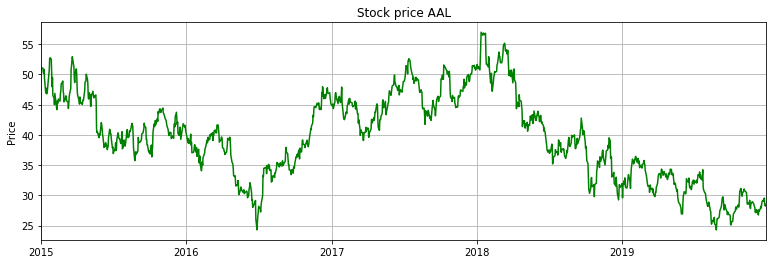

In [4]:
plt.figure(figsize=(13,4))
plt.title('Stock price '+ ticker)
plt.ylabel('Price')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['Adj Close'], color='g')
plt.show()

In [5]:
y = df['Adj Close'].values.astype(float)

test_size = 21
train_set = y[:-test_size]
test_set = y[-test_size:]

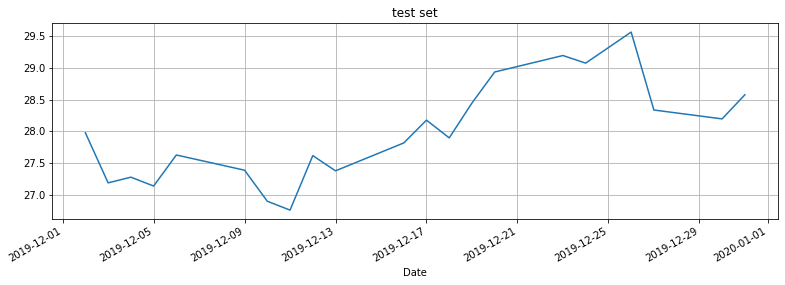

In [6]:
df['Adj Close'].iloc[-test_size:].plot(figsize=(13,4))
plt.title('test set')
plt.grid(True)

# Normalizing data
convert to range [-1, 1]

In [7]:
scaler = MinMaxScaler(feature_range=(-1, 1))
train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

In [8]:
train_norm.min()

-1.0000000000000002

In [9]:
train_norm.max()

1.0

In [10]:
train_norm.mean()

-0.04827459590507826

In [11]:
train_norm.std()

0.4333788652445345

# Input data and label
window size = 21

[1, 2, 3, ...,21] predict ==> [22]

In [12]:
train_norm = torch.FloatTensor(train_norm).view(-1)

window_size = 21


def input_data(seq,ws): 
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

train_data = input_data(train_norm,window_size)
len(train_data)  

1217

In [13]:
1259-21-21

1217

In [14]:
train_data[0]

(tensor([0.6225, 0.6387, 0.6369, 0.5883, 0.5865, 0.6242, 0.5292, 0.3878, 0.4353,
         0.3780, 0.3780, 0.4011, 0.5715, 0.6248, 0.7360, 0.7418, 0.7279, 0.5686,
         0.4481, 0.5419, 0.3588]),
 tensor([0.3380]))

# 1. LSTM network
lstm 1 layer 100 nodes 

fully connected 1 layer

In [15]:
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        self.linear = nn.Linear(hidden_size,output_size)
        
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1] 
        

In [16]:
torch.manual_seed(101)
model = LSTMnetwork()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

LSTMnetwork(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

# Training

50 epochs

In [25]:
epochs = 50
losses = []

import time
start_time = time.time()

for epoch in range(epochs):
    for seq, y_train in train_data:
        
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.00044133
Epoch:  2 Loss: 0.00000168
Epoch:  3 Loss: 0.00002277
Epoch:  4 Loss: 0.00002270
Epoch:  5 Loss: 0.00002739
Epoch:  6 Loss: 0.00001798
Epoch:  7 Loss: 0.00027617
Epoch:  8 Loss: 0.00006761
Epoch:  9 Loss: 0.00007635
Epoch: 10 Loss: 0.00073969
Epoch: 11 Loss: 0.00025235
Epoch: 12 Loss: 0.00048002
Epoch: 13 Loss: 0.00020199
Epoch: 14 Loss: 0.00011439
Epoch: 15 Loss: 0.00008303
Epoch: 16 Loss: 0.00020675
Epoch: 17 Loss: 0.00025484
Epoch: 18 Loss: 0.00031467
Epoch: 19 Loss: 0.00054494
Epoch: 20 Loss: 0.00029502
Epoch: 21 Loss: 0.00065618
Epoch: 22 Loss: 0.00012705
Epoch: 23 Loss: 0.00057139
Epoch: 24 Loss: 0.00014695
Epoch: 25 Loss: 0.00066314
Epoch: 26 Loss: 0.00070650
Epoch: 27 Loss: 0.00034200
Epoch: 28 Loss: 0.00039518
Epoch: 29 Loss: 0.00059030
Epoch: 30 Loss: 0.00007944
Epoch: 31 Loss: 0.00029011
Epoch: 32 Loss: 0.00000074
Epoch: 33 Loss: 0.00002577
Epoch: 34 Loss: 0.00003906
Epoch: 35 Loss: 0.00035362
Epoch: 36 Loss: 0.00000663
Epoch: 37 Loss: 0.00006044
E

# Loss

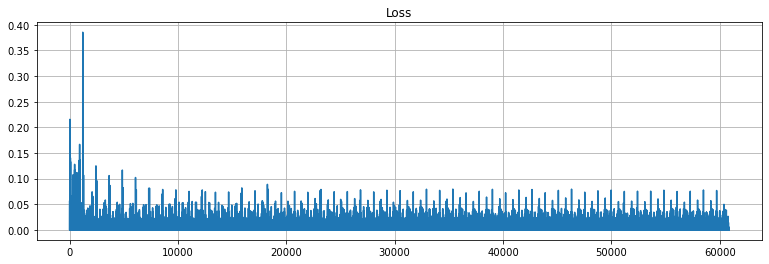

In [36]:
loss = pd.DataFrame(losses, columns=['loss'])
loss['loss'].plot(figsize=(13,4))
plt.title('Loss')
plt.grid(True)

# Forecast
21 days in future

In [37]:
future = 21

preds = train_norm[-window_size:].tolist()

model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())
        

In [38]:
preds[window_size:] 

[-0.7432088255882263,
 -0.7524678707122803,
 -0.7596627473831177,
 -0.7617163062095642,
 -0.7571216821670532,
 -0.7465653419494629,
 -0.7302560210227966,
 -0.7084932923316956,
 -0.6843202114105225,
 -0.6637725234031677,
 -0.647629976272583,
 -0.6373522877693176,
 -0.6296717524528503,
 -0.623650848865509,
 -0.6188011765480042,
 -0.6161442995071411,
 -0.6165567636489868,
 -0.6186381578445435,
 -0.6212112307548523,
 -0.6238282322883606,
 -0.6263883709907532]

In [39]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
true_predictions

array([[28.48076408],
       [28.32934417],
       [28.21168111],
       [28.17809777],
       [28.253237  ],
       [28.42587252],
       [28.69259072],
       [29.04849247],
       [29.44381247],
       [29.77984378],
       [30.04383461],
       [30.21191313],
       [30.33751852],
       [30.43598274],
       [30.51529297],
       [30.55874281],
       [30.55199748],
       [30.51795893],
       [30.47587959],
       [30.43308186],
       [30.39121405]])

In [41]:
df1 = pd.DataFrame(true_predictions, index=df.tail(21).index, columns=['pred'])

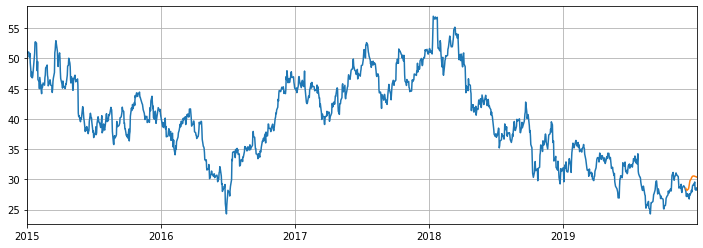

In [42]:
plt.figure(figsize=(12,4))
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['Adj Close'])
plt.plot(df1['pred'])
plt.show()

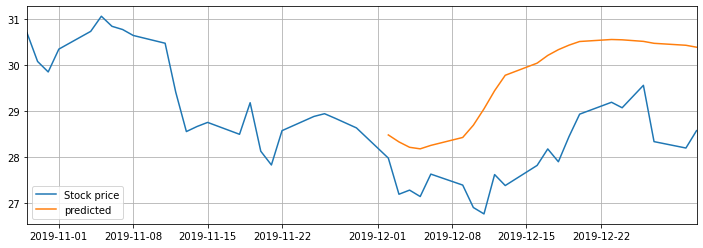

In [48]:
plt.figure(figsize=(12,4))
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['Adj Close'].iloc[-44:], label='Stock price')
plt.plot(df1['pred'], label='predicted')
plt.legend()

# Absolute mean squared error

In [49]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(true_predictions.reshape(1, -1), df['Adj Close'][-21:].values.reshape(1, -1)))

1.716845055990228

# Training
100 epochs

In [16]:
epochs = 100
losses = []

import time
start_time = time.time()

for epoch in range(epochs):
    for seq, y_train in train_data:
        
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.00044133
Epoch:  2 Loss: 0.00000168
Epoch:  3 Loss: 0.00002277
Epoch:  4 Loss: 0.00002270
Epoch:  5 Loss: 0.00002739
Epoch:  6 Loss: 0.00001798
Epoch:  7 Loss: 0.00027617
Epoch:  8 Loss: 0.00006761
Epoch:  9 Loss: 0.00007635
Epoch: 10 Loss: 0.00073969
Epoch: 11 Loss: 0.00025235
Epoch: 12 Loss: 0.00048002
Epoch: 13 Loss: 0.00020199
Epoch: 14 Loss: 0.00011439
Epoch: 15 Loss: 0.00008303
Epoch: 16 Loss: 0.00020675
Epoch: 17 Loss: 0.00025484
Epoch: 18 Loss: 0.00031467
Epoch: 19 Loss: 0.00054494
Epoch: 20 Loss: 0.00029502
Epoch: 21 Loss: 0.00065618
Epoch: 22 Loss: 0.00012705
Epoch: 23 Loss: 0.00057139
Epoch: 24 Loss: 0.00014695
Epoch: 25 Loss: 0.00066314
Epoch: 26 Loss: 0.00070650
Epoch: 27 Loss: 0.00034200
Epoch: 28 Loss: 0.00039518
Epoch: 29 Loss: 0.00059030
Epoch: 30 Loss: 0.00007944
Epoch: 31 Loss: 0.00029011
Epoch: 32 Loss: 0.00000074
Epoch: 33 Loss: 0.00002577
Epoch: 34 Loss: 0.00003906
Epoch: 35 Loss: 0.00035362
Epoch: 36 Loss: 0.00000663
Epoch: 37 Loss: 0.00006044
E

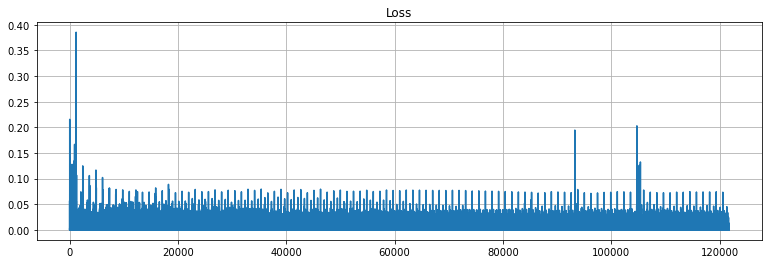

In [17]:
loss = pd.DataFrame(losses, columns=['loss'])
loss['loss'].plot(figsize=(13,4))
plt.title('Loss')
plt.grid(True)

# Forecast
21 days in future

In [20]:
future = 21

preds = train_norm[-window_size:].tolist()

model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())

In [22]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))

In [23]:
df1 = pd.DataFrame(true_predictions, index=df.tail(21).index, columns=['pred'])

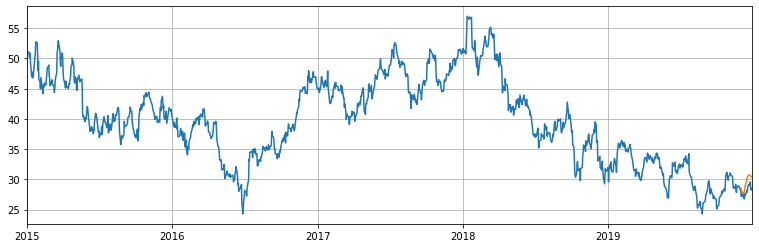

In [25]:
plt.figure(figsize=(13,4))
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['Adj Close'])
plt.plot(df1['pred'])
plt.show()

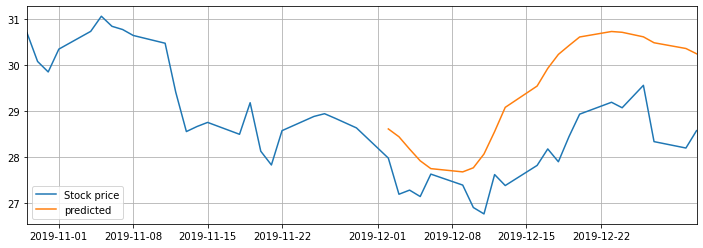

In [27]:
plt.figure(figsize=(12,4))
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['Adj Close'].iloc[-44:], label='Stock price')
plt.plot(df1['pred'], label='predicted')
plt.legend()

# Absolute mean squared error


In [26]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(true_predictions.reshape(1, -1), df['Adj Close'][-21:].values.reshape(1, -1)))

1.4847460237668748

# Training
200 epochs

In [17]:
epochs = 200
losses = []

import time
start_time = time.time()

for epoch in range(epochs):
    for seq, y_train in train_data:
        
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.00044133
Epoch:  2 Loss: 0.00000168
Epoch:  3 Loss: 0.00002277
Epoch:  4 Loss: 0.00002270
Epoch:  5 Loss: 0.00002739
Epoch:  6 Loss: 0.00001798
Epoch:  7 Loss: 0.00027617
Epoch:  8 Loss: 0.00006761
Epoch:  9 Loss: 0.00007635
Epoch: 10 Loss: 0.00073969
Epoch: 11 Loss: 0.00025235
Epoch: 12 Loss: 0.00048002
Epoch: 13 Loss: 0.00020199
Epoch: 14 Loss: 0.00011439
Epoch: 15 Loss: 0.00008303
Epoch: 16 Loss: 0.00020675
Epoch: 17 Loss: 0.00025484
Epoch: 18 Loss: 0.00031467
Epoch: 19 Loss: 0.00054494
Epoch: 20 Loss: 0.00029502
Epoch: 21 Loss: 0.00065618
Epoch: 22 Loss: 0.00012705
Epoch: 23 Loss: 0.00057139
Epoch: 24 Loss: 0.00014695
Epoch: 25 Loss: 0.00066314
Epoch: 26 Loss: 0.00070650
Epoch: 27 Loss: 0.00034200
Epoch: 28 Loss: 0.00039518
Epoch: 29 Loss: 0.00059030
Epoch: 30 Loss: 0.00007944
Epoch: 31 Loss: 0.00029011
Epoch: 32 Loss: 0.00000074
Epoch: 33 Loss: 0.00002577
Epoch: 34 Loss: 0.00003906
Epoch: 35 Loss: 0.00035362
Epoch: 36 Loss: 0.00000663
Epoch: 37 Loss: 0.00006044
E

# Loss

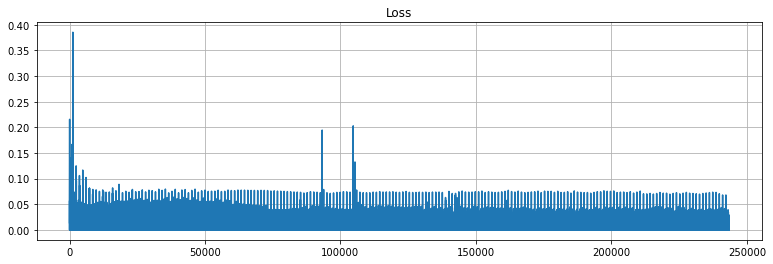

In [18]:
loss = pd.DataFrame(losses, columns=['loss'])
loss['loss'].plot(figsize=(13,4))
plt.title('Loss')
plt.grid(True)

# Forecast
21 days in future

In [19]:
future = 21

preds = train_norm[-window_size:].tolist()

model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())
        

In [20]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))

In [21]:
df1 = pd.DataFrame(true_predictions, index=df.tail(21).index, columns=['pred'])

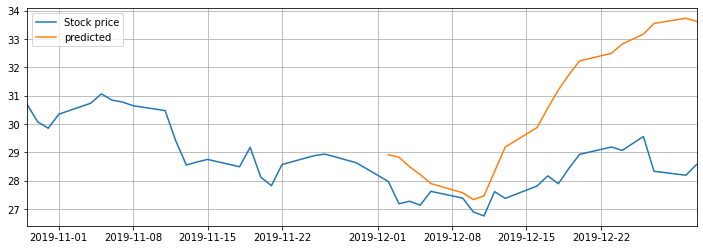

In [22]:
plt.figure(figsize=(12,4))
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['Adj Close'].iloc[-44:], label='Stock price')
plt.plot(df1['pred'], label='predicted')
plt.legend()

# Absolute mean squared error


In [23]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(true_predictions.reshape(1, -1), df['Adj Close'][-21:].values.reshape(1, -1)))

2.8860278839088203

# 2. LSTM network
lstm 2 layers 100 nodes

fully connected 1 l layer

In [15]:
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=[100, 100], output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.lstm1 = nn.LSTM(input_size,hidden_size[0])
        
        self.lstm2 = nn.LSTM(hidden_size[0], hidden_size[1])
        
        self.linear = nn.Linear(hidden_size[1], output_size)
        
        self.hidden = (torch.zeros(1,1,self.hidden_size[0]),
                       torch.zeros(1,1,self.hidden_size[0]))

    def forward(self,seq):
        lstm_out1, self.hidden = self.lstm1(seq.view(len(seq),1,-1), self.hidden)
        lstm_out2, self.hidden = self.lstm2(lstm_out1.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out2.view(len(seq),-1))
        return pred[-1] 
        

In [16]:
torch.manual_seed(101)
model = LSTMnetwork()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

LSTMnetwork(
  (lstm1): LSTM(1, 100)
  (lstm2): LSTM(100, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

# Training 
50 epochs

In [17]:
epochs = 50
losses= []

import time
start_time = time.time()

for epoch in range(epochs):
    for seq, y_train in train_data:
        
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size[0]),
                        torch.zeros(1,1,model.hidden_size[0]))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.00954857
Epoch:  2 Loss: 0.00366953
Epoch:  3 Loss: 0.00189236
Epoch:  4 Loss: 0.00114734
Epoch:  5 Loss: 0.00111783
Epoch:  6 Loss: 0.00084788
Epoch:  7 Loss: 0.00019628
Epoch:  8 Loss: 0.00045160
Epoch:  9 Loss: 0.00007489
Epoch: 10 Loss: 0.00002189
Epoch: 11 Loss: 0.00000174
Epoch: 12 Loss: 0.00000577
Epoch: 13 Loss: 0.00003166
Epoch: 14 Loss: 0.00024646
Epoch: 15 Loss: 0.00004256
Epoch: 16 Loss: 0.00023639
Epoch: 17 Loss: 0.00016372
Epoch: 18 Loss: 0.00128290
Epoch: 19 Loss: 0.00014275
Epoch: 20 Loss: 0.00003823
Epoch: 21 Loss: 0.00009996
Epoch: 22 Loss: 0.00001693
Epoch: 23 Loss: 0.00000876
Epoch: 24 Loss: 0.00024428
Epoch: 25 Loss: 0.00398669
Epoch: 26 Loss: 0.00008161
Epoch: 27 Loss: 0.00028497
Epoch: 28 Loss: 0.00021234
Epoch: 29 Loss: 0.00017733
Epoch: 30 Loss: 0.00008264
Epoch: 31 Loss: 0.00001190
Epoch: 32 Loss: 0.00045374
Epoch: 33 Loss: 0.00000000
Epoch: 34 Loss: 0.00107932
Epoch: 35 Loss: 0.00000141
Epoch: 36 Loss: 0.00000106
Epoch: 37 Loss: 0.00000923
E

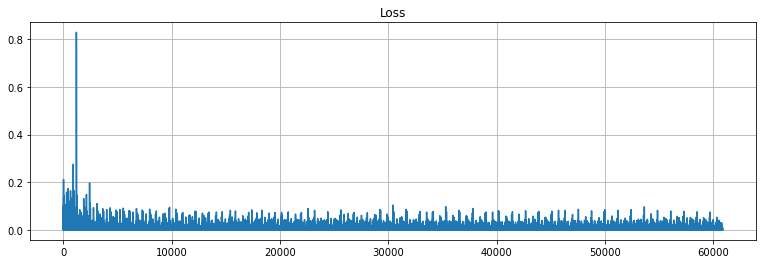

In [18]:
loss = pd.DataFrame(losses, columns=['loss'])
loss['loss'].plot(figsize=(13,4))
plt.title('Loss')
plt.grid(True)

# Forecast
21 days in future

In [19]:
future = 21

preds = train_norm[-window_size:].tolist()

model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size[0]),
                        torch.zeros(1,1,model.hidden_size[0]))
        preds.append(model(seq).item())

In [20]:
preds[-window_size:]

[-0.757402777671814,
 -0.7874175310134888,
 -0.8152780532836914,
 -0.8314396142959595,
 -0.8290495276451111,
 -0.8068031072616577,
 -0.7629567384719849,
 -0.7060754895210266,
 -0.6504136323928833,
 -0.6092550754547119,
 -0.5847592949867249,
 -0.5712786316871643,
 -0.564176082611084,
 -0.5582292079925537,
 -0.5538508296012878,
 -0.5535568594932556,
 -0.5571625232696533,
 -0.5620911121368408,
 -0.5666959285736084,
 -0.5702804923057556,
 -0.5728135704994202]

In [21]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
true_predictions

array([[28.24864004],
       [27.75778692],
       [27.30216351],
       [27.03786173],
       [27.07694856],
       [27.44076047],
       [28.15781207],
       [29.08803256],
       [29.99831145],
       [30.67140731],
       [31.07200465],
       [31.29246375],
       [31.40861691],
       [31.50587048],
       [31.57747329],
       [31.5822808 ],
       [31.52331475],
       [31.44271395],
       [31.36740803],
       [31.30878705],
       [31.26736178]])

In [22]:
df1 = pd.DataFrame(true_predictions, index=df.tail(21).index, columns=['pred'])

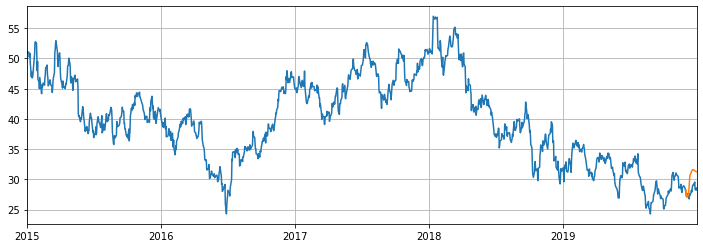

In [23]:
plt.figure(figsize=(12,4))
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['Adj Close'])
plt.plot(df1['pred'])
plt.show()

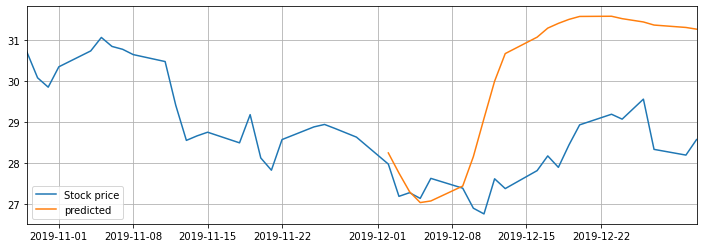

In [24]:
plt.figure(figsize=(12,4))
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['Adj Close'].iloc[-44:], label='Stock price')
plt.plot(df1['pred'], label='predicted')
plt.legend()


# Absolute mean squared error


In [25]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(true_predictions.reshape(1, -1), df['Adj Close'][-21:].values.reshape(1, -1)))

2.336208751374393

# Training 
100 epochs

In [15]:
epochs = 100
losses= []

import time
start_time = time.time()

for epoch in range(epochs):
    for seq, y_train in train_data:
        
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size[0]),
                        torch.zeros(1,1,model.hidden_size[0]))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.00954857
Epoch:  2 Loss: 0.00366953
Epoch:  3 Loss: 0.00189236
Epoch:  4 Loss: 0.00114734
Epoch:  5 Loss: 0.00111783
Epoch:  6 Loss: 0.00084788
Epoch:  7 Loss: 0.00019628
Epoch:  8 Loss: 0.00045160
Epoch:  9 Loss: 0.00007489
Epoch: 10 Loss: 0.00002189
Epoch: 11 Loss: 0.00000174
Epoch: 12 Loss: 0.00000577
Epoch: 13 Loss: 0.00003166
Epoch: 14 Loss: 0.00024646
Epoch: 15 Loss: 0.00004256
Epoch: 16 Loss: 0.00023639
Epoch: 17 Loss: 0.00016372
Epoch: 18 Loss: 0.00128290
Epoch: 19 Loss: 0.00014275
Epoch: 20 Loss: 0.00003823
Epoch: 21 Loss: 0.00009996
Epoch: 22 Loss: 0.00001693
Epoch: 23 Loss: 0.00000876
Epoch: 24 Loss: 0.00024428
Epoch: 25 Loss: 0.00398669
Epoch: 26 Loss: 0.00008161
Epoch: 27 Loss: 0.00028497
Epoch: 28 Loss: 0.00021234
Epoch: 29 Loss: 0.00017733
Epoch: 30 Loss: 0.00008264
Epoch: 31 Loss: 0.00001190
Epoch: 32 Loss: 0.00045374
Epoch: 33 Loss: 0.00000000
Epoch: 34 Loss: 0.00107932
Epoch: 35 Loss: 0.00000141
Epoch: 36 Loss: 0.00000106
Epoch: 37 Loss: 0.00000923
E

# Loss

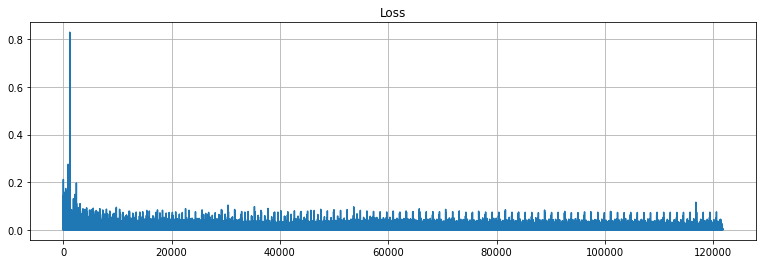

In [16]:
loss = pd.DataFrame(losses, columns=['loss'])
loss['loss'].plot(figsize=(13,4))
plt.title('Loss')
plt.grid(True)

# Forecast
21 days in future

In [17]:
future = 21

preds = train_norm[-window_size:].tolist()

model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size[0]),
                        torch.zeros(1,1,model.hidden_size[0]))
        preds.append(model(seq).item())

In [18]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))

In [19]:
df1 = pd.DataFrame(true_predictions, index=df.tail(21).index, columns=['pred'])

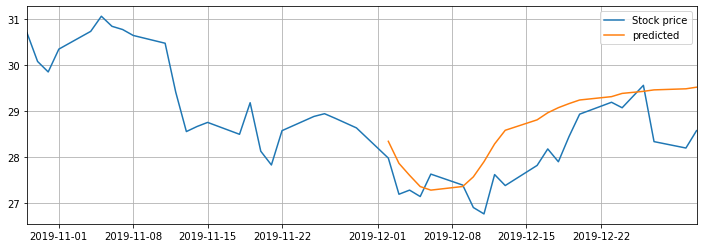

In [20]:
plt.figure(figsize=(12,4))
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['Adj Close'].iloc[-44:], label='Stock price')
plt.plot(df1['pred'], label='predicted')
plt.legend()

#  Absolute mean squared error


In [21]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(true_predictions.reshape(1, -1), df['Adj Close'][-21:].values.reshape(1, -1)))

0.7575290193311391

# Training
200 epochs

In [17]:
epochs = 200
losses= []

import time
start_time = time.time()

for epoch in range(epochs):
    for seq, y_train in train_data:
        
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size[0]),
                        torch.zeros(1,1,model.hidden_size[0]))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.00954857
Epoch:  2 Loss: 0.00366953
Epoch:  3 Loss: 0.00189236
Epoch:  4 Loss: 0.00114734
Epoch:  5 Loss: 0.00111783
Epoch:  6 Loss: 0.00084788
Epoch:  7 Loss: 0.00019628
Epoch:  8 Loss: 0.00045160
Epoch:  9 Loss: 0.00007489
Epoch: 10 Loss: 0.00002189
Epoch: 11 Loss: 0.00000174
Epoch: 12 Loss: 0.00000577
Epoch: 13 Loss: 0.00003166
Epoch: 14 Loss: 0.00024646
Epoch: 15 Loss: 0.00004256
Epoch: 16 Loss: 0.00023639
Epoch: 17 Loss: 0.00016372
Epoch: 18 Loss: 0.00128290
Epoch: 19 Loss: 0.00014275
Epoch: 20 Loss: 0.00003823
Epoch: 21 Loss: 0.00009996
Epoch: 22 Loss: 0.00001693
Epoch: 23 Loss: 0.00000876
Epoch: 24 Loss: 0.00024428
Epoch: 25 Loss: 0.00398669
Epoch: 26 Loss: 0.00008161
Epoch: 27 Loss: 0.00028497
Epoch: 28 Loss: 0.00021234
Epoch: 29 Loss: 0.00017733
Epoch: 30 Loss: 0.00008264
Epoch: 31 Loss: 0.00001190
Epoch: 32 Loss: 0.00045374
Epoch: 33 Loss: 0.00000000
Epoch: 34 Loss: 0.00107932
Epoch: 35 Loss: 0.00000141
Epoch: 36 Loss: 0.00000106
Epoch: 37 Loss: 0.00000923
E

# Loss 

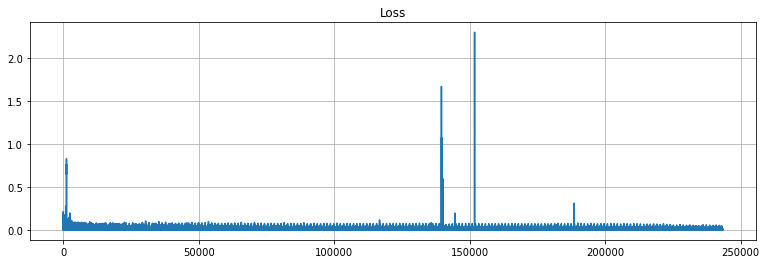

In [18]:
loss = pd.DataFrame(losses, columns=['loss'])
loss['loss'].plot(figsize=(13,4))
plt.title('Loss')
plt.grid(True)

# Forecast
21 days in the future

In [19]:
future = 21

preds = train_norm[-window_size:].tolist()

model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size[0]),
                        torch.zeros(1,1,model.hidden_size[0]))
        preds.append(model(seq).item())

In [20]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))

In [21]:
df1 = pd.DataFrame(true_predictions, index=df.tail(21).index, columns=['pred'])

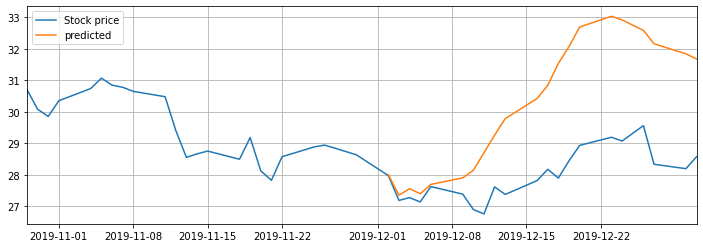

In [22]:
plt.figure(figsize=(12,4))
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['Adj Close'].iloc[-44:], label='Stock price')
plt.plot(df1['pred'], label='predicted')
plt.legend()

#  Absolute mean squared error


In [23]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(true_predictions.reshape(1, -1), df['Adj Close'][-21:].values.reshape(1, -1)))

2.6232999793128284

# 3. LSTM network
lstm 3 layers 100 nodes

fully connected 1 l layer

In [15]:
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=[100, 100, 100], output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.lstm1 = nn.LSTM(input_size,hidden_size[0])
        
        self.lstm2 = nn.LSTM(hidden_size[0], hidden_size[1])
        
        self.lstm3 = nn.LSTM(hidden_size[1], hidden_size[2])
        
        self.linear = nn.Linear(hidden_size[2], output_size)
        
        self.hidden = (torch.zeros(1,1,self.hidden_size[0]),
                       torch.zeros(1,1,self.hidden_size[0]))

    def forward(self,seq):
        lstm_out1, self.hidden = self.lstm1(seq.view(len(seq),1,-1), self.hidden)
        lstm_out2, self.hidden = self.lstm2(lstm_out1.view(len(seq),1,-1), self.hidden)
        lstm_out3, self.hidden = self.lstm3(lstm_out2.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out3.view(len(seq),-1))
        return pred[-1] 
        

In [16]:
torch.manual_seed(101)
model = LSTMnetwork()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

LSTMnetwork(
  (lstm1): LSTM(1, 100)
  (lstm2): LSTM(100, 100)
  (lstm3): LSTM(100, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

# Training 
50 epochs

In [17]:
epochs = 50
losses= []

import time
start_time = time.time()

for epoch in range(epochs):
    for seq, y_train in train_data:
        
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size[0]),
                        torch.zeros(1,1,model.hidden_size[0]))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.00356443
Epoch:  2 Loss: 0.00226266
Epoch:  3 Loss: 0.00800271
Epoch:  4 Loss: 0.00602903
Epoch:  5 Loss: 0.00064428
Epoch:  6 Loss: 0.00008184
Epoch:  7 Loss: 0.00000294
Epoch:  8 Loss: 0.00001670
Epoch:  9 Loss: 0.00066054
Epoch: 10 Loss: 0.00053633
Epoch: 11 Loss: 0.00023945
Epoch: 12 Loss: 0.00001337
Epoch: 13 Loss: 0.00213530
Epoch: 14 Loss: 0.00004198
Epoch: 15 Loss: 0.00005115
Epoch: 16 Loss: 0.00016029
Epoch: 17 Loss: 0.00314854
Epoch: 18 Loss: 0.00000102
Epoch: 19 Loss: 0.00000140
Epoch: 20 Loss: 0.00000060
Epoch: 21 Loss: 0.00036036
Epoch: 22 Loss: 0.00010867
Epoch: 23 Loss: 0.00002593
Epoch: 24 Loss: 0.00003602
Epoch: 25 Loss: 0.00003960
Epoch: 26 Loss: 0.00004102
Epoch: 27 Loss: 0.00004160
Epoch: 28 Loss: 0.00004184
Epoch: 29 Loss: 0.00004194
Epoch: 30 Loss: 0.00464079
Epoch: 31 Loss: 0.00168294
Epoch: 32 Loss: 0.00111850
Epoch: 33 Loss: 0.00098950
Epoch: 34 Loss: 0.00094299
Epoch: 35 Loss: 0.00092441
Epoch: 36 Loss: 0.00091674
Epoch: 37 Loss: 0.00091349
E

# Loss

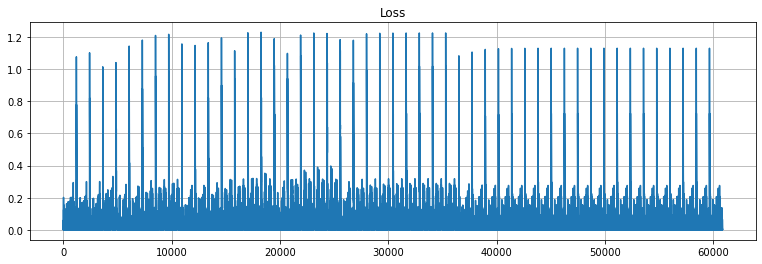

In [18]:
loss = pd.DataFrame(losses, columns=['loss'])
loss['loss'].plot(figsize=(13,4))
plt.title('Loss')
plt.grid(True)

# Forecast
21 days in future

In [19]:
future = 21

preds = train_norm[-window_size:].tolist()

model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size[0]),
                        torch.zeros(1,1,model.hidden_size[0]))
        preds.append(model(seq).item())

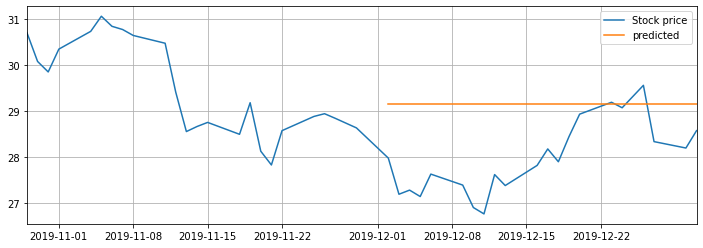

In [20]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
df1 = pd.DataFrame(true_predictions, index=df.tail(21).index, columns=['pred'])
plt.figure(figsize=(12,4))
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['Adj Close'].iloc[-44:], label='Stock price')
plt.plot(df1['pred'], label='predicted')
plt.legend()

# Absolute mean squared error

In [21]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(true_predictions.reshape(1, -1), df['Adj Close'][-21:].values.reshape(1, -1)))

1.4071204253875638